# Sampling Techniques

1. Imports and constants
2. Loading price and text data
3. Volatility-Based event sampling
4. Sentiment-Imbalance event sampling
6. Compare to actual events

## Imports and Constants

In [1]:
import os
import sys
current_working_directory = os.getcwd()
new_path = os.path.join(os.path.dirname(current_working_directory), "src")
if new_path not in sys.path:
    sys.path.append(new_path)

In [2]:
import datetime
import random
from datetime import timedelta
from typing import List, Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from transformers import (
    AutoTokenizer,
    AutoModel,
)
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, ClassLabel


# internal imports
from type import Experiment
from model import CryptoBERT
from labeler import TripleBarrierLabeler, TrueRangeLabeler
from dataset import HFDataset, TextDataset
from util import *
from functools import partial

import neptune

## Load price and textual data

In [3]:
def pandas_data_loader(addr: str, columns: List[str], *transforms: Callable[[pd.DataFrame], pd.DataFrame]) -> pd.DataFrame:
    # Load the data from the CSV file
    df = pd.read_csv(addr, usecols=columns)

    # Apply each transform to the DataFrame
    for transform in transforms:
        df = transform(df)

    return df

In [4]:
# Transform index to datetime
def index_to_datetime(df, unit="s"):
    df.index = pd.to_datetime(df.index, unit=unit)
    return df
# Transform col to index
to_index = lambda col, df: df.set_index(col)
# Rename text_plit to text
rename = lambda original, new, df: df.rename(columns={original: new})

In [5]:
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume"]
price_df = pandas_data_loader("../raw/daily-2020.csv", columns, partial(to_index, "timestamp"), index_to_datetime)

In [9]:
columns = ["text", "date", "sentiment_label"]
text_df = pandas_data_loader("../raw/labeled_tweets.csv", columns, partial(to_index, "date"), partial(index_to_datetime, unit='ns'))

In [ ]:
# make the same data for price and text
# text_df = text_df['2020-01-01':'2020-12-31']
# text_df

In [10]:
print(text_df['sentiment_label'].value_counts())
#"Bearish" : 0, "Neutral": 1, "Bullish": 2

sentiment_label
2    193629
1    126242
0        99
Name: count, dtype: int64


In [11]:
grouped = text_df.groupby(['date', 'sentiment_label']).size().unstack(fill_value=0)

# Calculate the ratio of label 2 to label 1
grouped['ratio_2_to_1'] = grouped[2] / grouped[1]

# Replace inf values with NaN (in case there are days without label 1)
grouped['ratio_2_to_1'].replace(float('inf'), pd.NA, inplace=True)

# Display the result
print(grouped[['ratio_2_to_1']])

sentiment_label ratio_2_to_1
date                        
2015-01-01          1.782609
2015-01-02             0.975
2015-01-03              0.25
2015-01-04          0.568627
2015-01-05          0.290909
...                      ...
2021-02-11          1.319149
2021-02-12          1.351064
2021-02-13          1.390805
2021-02-14          1.104762
2021-02-15          1.235294

[2142 rows x 1 columns]


In [16]:
def calculate_non_overlapping_means(df, window_size):
    # Split the DataFrame into chunks of window_size
    chunks = [df.iloc[i:i + window_size] for i in range(0, len(df), window_size)]

    results = []
    for chunk in chunks:
        chunk = chunk.copy()  # Create a copy of the chunk before modifying it
        mean = chunk['ratio_2_to_1'].mean()
        std = chunk['ratio_2_to_1'].std()
        lower_bound = mean - (std * 1)
        upper_bound = mean + (std * 1)
        chunk['event'] = 'False'
        chunk.loc[chunk['ratio_2_to_1'] > upper_bound, 'event'] = 'True-g'
        chunk.loc[chunk['ratio_2_to_1'] < lower_bound, 'event'] = 'True-y'
        results.append(chunk)

    # Concatenate the results back into a single DataFrame
    return pd.concat(results)

In [33]:
window_size = 60
new_grouped = calculate_non_overlapping_means(grouped, window_size)

In [34]:
new_grouped['event'].value_counts()

event
False     1606
True-g     297
True-y     239
Name: count, dtype: int64

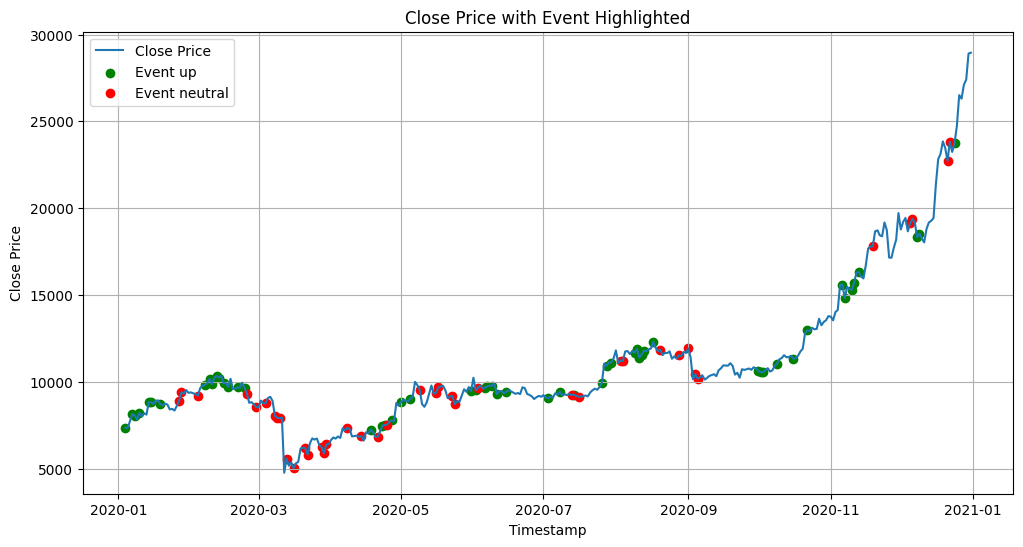

In [35]:
price_df['event2'] = new_grouped['event'][3:]
plt.figure(figsize=(12, 6))
plt.plot(price_df.index, price_df['close'], label='Close Price')

# Highlight points where event is True
event_true_g = price_df[price_df['event2'] == 'True-g']
event_true_y = price_df[price_df['event2'] == 'True-y']
# event_true
plt.scatter(event_true_g.index, event_true_g['close'], color='green', label='Event up')
plt.scatter(event_true_y.index, event_true_y['close'], color='red', label='Event neutral')

plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Close Price with Event Highlighted')
plt.legend()
plt.grid(True)
plt.show()

## Volatility-Based Event Sampling

In [22]:
def get_daily_vol(close, span0=100):
    """
    Calculate the daily volatility of closing prices.
    
    Parameters:
    - close: A pandas Series of closing prices.
    - span0: The span for the EWM standard deviation.
    
    Returns:
    - A pandas Series of daily volatility estimates.
    """
    # Find the start of the previous day for each day
    prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    prev_day_start = prev_day_start[prev_day_start > 0]
    
    # Create a series with the start of the previous day for each day
    prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])
    
    # Calculate daily returns
    daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1
    
    # Calculate EWM standard deviation of daily returns
    daily_vol = daily_returns.ewm(span=span0).std()
    
    return daily_returns, daily_vol

In [23]:
price_df["daily_returns"], price_df["volatility"] = get_daily_vol(price_df.close)

In [24]:
price_df.dropna(inplace=True)

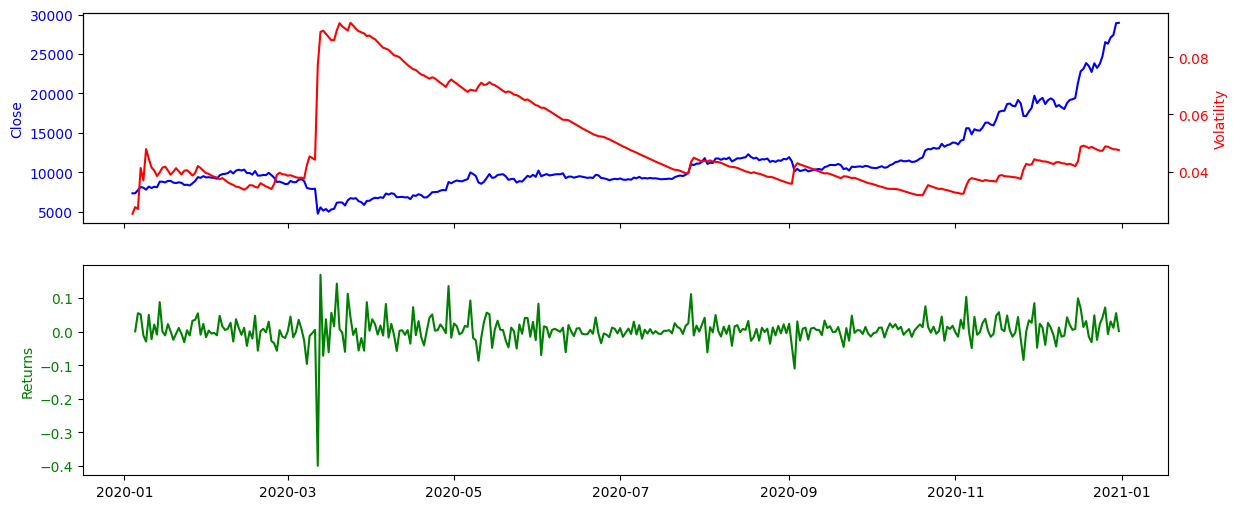

In [25]:
# Calculate returns
price_df['returns'] = price_df['close'].pct_change()

# Create a new figure with two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))

# Plot 'close' on the primary y-axis of the first subplot
ax1.plot(price_df.index, price_df['close'], color='blue')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'volatility' on the first subplot
ax2 = ax1.twinx()
ax2.plot(price_df.index, price_df['volatility'], color='red')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot 'returns' on the second subplot
ax3.plot(price_df.index, price_df['returns'], color='green')
ax3.set_ylabel('Returns', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Show the plot
plt.show()

In [26]:
def get_t_events(raw_price, volatility, base_threshold):
    """
    :param raw_price: (series) of close prices.
    :param volatility: (series) of volatility values.
    :param base_threshold: (float) base level for the threshold.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events, s_pos, s_neg = [], 0, 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        # Adjust the threshold based on volatility
        threshold = base_threshold * volatility.loc[i]
        
        s_pos = max(0.0, float(s_pos + diff.loc[i]))
        s_neg = min(0.0, float(s_neg + diff.loc[i]))

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [27]:
events = get_t_events(price_df.close, price_df.volatility, 1.5)

Applying Symmetric CUSUM filter.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [00:00<00:00, 16181.24it/s]


In [28]:
price_df["event"] = price_df.index.isin(events)

In [29]:
price_df.event.value_counts()

event
False    308
True      55
Name: count, dtype: int64

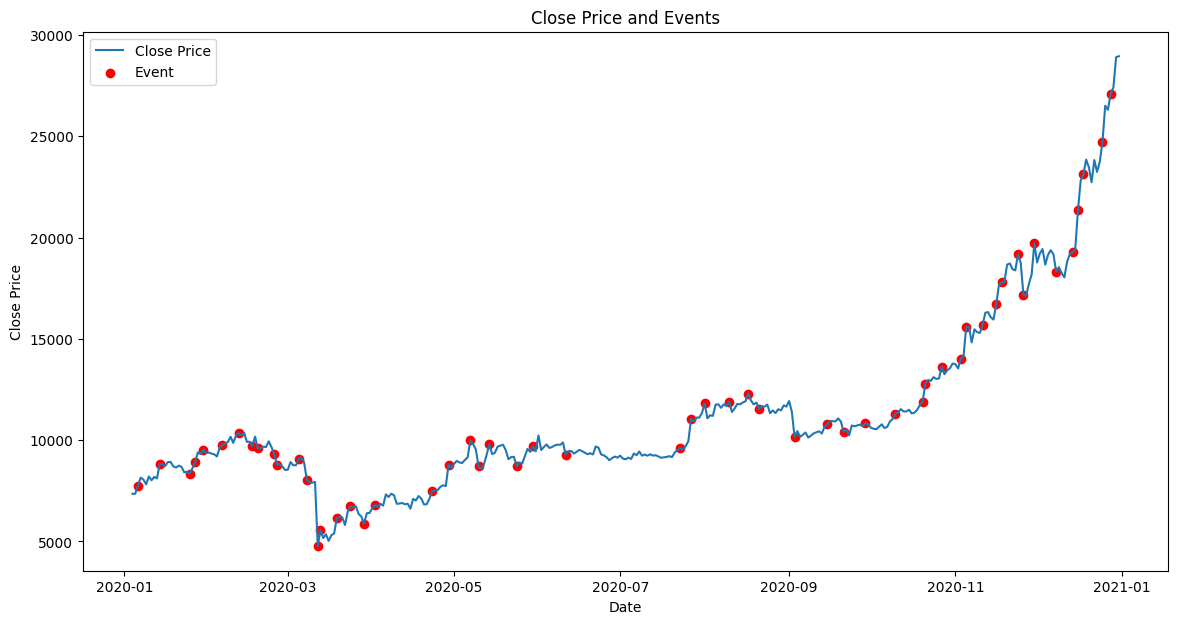

In [32]:
def plot_close_and_events(price_df):
    # Create a new figure and set the size
    plt.figure(figsize=(14, 7))

    # Plot the close price
    plt.plot(price_df.index, price_df['close'], label='Close Price')

    # Plot the events
    event_indices = price_df[price_df['event'] == True].index
    event_values = price_df.loc[event_indices, 'close']
    plt.scatter(event_indices, event_values, color='red', label='Event')

    # Set the title and labels
    plt.title('Close Price and Events')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

# Call the function with your DataFrame
plot_close_and_events(price_df)

In [36]:
def hybrid_event_sampling(raw_price, volatility, sentiment_ratio, base_threshold, window_size):
    # Volatility-based event detection
    t_events_volatility = get_t_events(raw_price, volatility, base_threshold)
    
    # Sentiment ratio-based event detection
    sentiment_events = calculate_non_overlapping_means(sentiment_ratio, window_size)
    
    # Combine events
    combined_events = t_events_volatility.union(sentiment_events.index)
    
    return combined_events

In [ ]:
hybrid_event_sampling()